In [0]:
!pip install spectrum

    100% |████████████████████████████████| 235kB 7.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/77/45/82/05503d66a576e2361ab90f4e93f4491c3b83211cfe4eafb581
Successfully built spectrum


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# packages for basic python calculation
import pandas as pd
import numpy as np
import os

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
#import spectrum
#from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# package for ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')



# defind function for data readin
def load_data(folder_path = "../data/buy/"):
    df_gp = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            stock = filename[0:4]
            # print("Loading stock data:", stock, ",")
            temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
            temp_df.rename(columns={123:'rtn'}, inplace=True)
            temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
            df_gp = pd.concat([df_gp, temp_df], ignore_index=True)
            df_gp.reset_index()
            continue
        else:
            continue
    
    # drop rows with NA
    rows_to_drop = []
    for i in range(df_gp.shape[0]):
        if sum(df_gp.iloc[i,:].isnull()):
            rows_to_drop.append(i)
    
    df_gp = df_gp.drop(rows_to_drop, axis=0)
    #df_gp = df_gp.iloc[:,1:]   
    
    # remove duplicates
    df_gp = df_gp.drop_duplicates(subset=df_gp.columns.difference(['stock']))
    
    # change data type
    df_gp.iloc[:, 1:] = df_gp.iloc[:, 1:].astype(float)
    
    df_gp = df_gp.reset_index(drop = True)
    return df_gp

# Data Loading

In [0]:
df_gp = load_data("/content/gdrive/My Drive/buy/")


# Function design

In [0]:
class OSC_analyzing_pipeline():
    
    """
    This class is designed and modified for the Seahorse program. It is applicable for Random Forest
    Classifier originally.
    
    Attributes:
    ----------------------------------------------------------------------------
    self.data: the input dataset that we will be using for training and testing
    self.model: the classifier we want to explore
    self.osc_gp: subset for the oscillator data
    * new addition: self.stk: subset for original stock data
    self.macd_gp: subset for the macd data
    self.rtn_gp: subset for the return values
    self.label_gp: the output for training and testing (the reponse variable)
    
    self.psd
    self.smooth
    self.first_derivitive_macd
    self.second_derivitive_macd
    self.first_derivitive_osc
    self.second_derivitive_osc
    self.partial_smooth
    
    self.feature_result_df: the feature matrix and label generated from the feature_generator function, it can be used to visual which feature is participated in model training
    self.X_train: to visual and further call the training dataset
    self.X_test: to visual and further call the test dataset
    self.y_train: to visual and further call the training dataset
    self.y_test: to visual and further call the test dataset
    
    self.report: generate the report to compare the winning rate with the original test
    The class object also contains all the attributes belongs to the model/classifier originally.
    
    Functions:
    ----------------------------------------------------------------------------
    * new addition: EDA_visualization(): function for visualization the record
    psd_calculator(): function calculate the fft values, callable with return value to be visualized
    smooth_calculator(): function for calculating the smoothness value, already modified and can handle the amplitude changes
    derivative_calculator(): function for calculating the derivitive for macd and osc
    features_generator(): function to decide which feature can be used in the final model training, the input is True/False for certain feature to be involved. In this function, all three function above will be called
    model_train(): training the model based on the feature matrix
    
    """
    
    # define the init
    def __init__(self, data):
        """
        Keyword argument:
        data -- (df) the input dataset for processing
        model -- (ML model) the classifier we are interested of, currently it is just the random forest
        """
        self.data = data
        
        # seperate indicators and returns
        # name_gp = df_gp.iloc[:, 0]
        self.osc_gp = self.data.iloc[:, 1:42]
        self.stk_gp = self.data.iloc[:, 42:83]
        self.macd_gp = self.data.iloc[:, 83:124]
        self.rtn_gp = self.data.iloc[:, 124]
        self.label_gp = np.sign(self.rtn_gp)
        self.label_gp = self.label_gp.map({1: 1, -1: 0, 0:0})
        self.results_gp = self.label_gp.map({1: 'EARN', 0: 'LOSS'})
        self.label_gp = pd.DataFrame({"label": self.label_gp})
        
    
    def EDA_visualization(self, index, osc_ind = True, stk_ind = False, macd_ind = False):
        if osc_ind:
            # plot Oscillator
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.osc_gp.iloc[index,:])
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("Oscillator")
            plt.xlabel("Time")
            plt.title("Oscillator 3-Day Time Series")
            plt.show()
        

        if stk_ind:
            # plot stock price
            plt.figure(figsize=(12,4))
            plt.plot(range(41), self.stk_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.ylabel("Stock Price")
            plt.xlabel("Time")
            plt.title("Stock Price 3-Day Time Series")
            plt.show()
    
        if macd_ind:
        # plot MACD
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.macd_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("MACD")
            plt.xlabel("Time")
            plt.title("MACD 3-Day Time Series")
            plt.show()
        
    # define function for psd calculation
    def psd_calculator(self, NFFT = 100, name = "osc"):
        """
        calculate the psd seq as new feature
        """
        freq = []
        for i in range(self.osc_gp.shape[0]):
            data_osc = self.osc_gp.iloc[i,:]
            p = Periodogram(data_osc, NFFT=NFFT)
            temp_list = list(p.psd)
            freq.append(temp_list)
        col_name = []
        for i in range(int(NFFT/2)+1):
            col_name.append("freq"+str(i))
    
        psd_df = pd.DataFrame(freq, columns=col_name)
        psd_df.index = self.osc_gp.index
        
        return psd_df
    
    # define function to calculate smoothness more directly
    def smooth_calculator(self):
        smooth_list = []
        for i in range(self.osc_gp.shape[0]):
            amp = np.mean(abs(self.osc_gp.iloc[i,:]))
            if amp == 0:
                smooth_list.append(0)
            else:
                smooth_list.append(np.var(np.diff(self.osc_gp.iloc[i,:]))/amp)
        
        smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 
        smooth.index = self.osc_gp.index

        return smooth
    
    # define the function to explore the influence of partial smoothness
    def smooth_partial(self):
        # get the nearest 10 points
        osc_10 = self.osc_gp.iloc[:,-10:]
        # calculate the smoothness of 10 points
        smooth_10 = []
        for i in range(osc_10.shape[0]):
            amp = np.mean(abs(osc_10.iloc[i,:]))
            if amp == 0:
                smooth_10.append(0)
            else:
                smooth_10.append(np.var(np.diff(osc_10.iloc[i,:]))/amp)
        
        
        # get the nearest 20 points
        osc_20 = self.osc_gp.iloc[:,-20:]
        smooth_20 = []
        for i in range(osc_20.shape[0]):
            amp = np.mean(abs(osc_20.iloc[i,:]))
            if amp == 0:
                smooth_20.append(0)
                
            else:
                smooth_20.append(np.var(np.diff(osc_20.iloc[i,:]))/(np.mean(abs(osc_20.iloc[i,:]))))
        
        # get the nearest 30 points
        osc_30 = self.osc_gp.iloc[:,-30:]
        smooth_30 = []
        for i in range(osc_30.shape[0]):
            amp = np.mean(abs(osc_30.iloc[i,:]))
            if amp == 0:
                smooth_30.append(0)
            else:
                smooth_30.append(np.var(np.diff(osc_30.iloc[i,:]))/(np.mean(abs(osc_30.iloc[i,:]))))
        
        partial_smooth = pd.DataFrame({"smooth_10": smooth_10,
                                      "smooth_20": smooth_20,
                                      "smooth_30": smooth_30,})
        
        partial_smooth.index = self.osc_gp.index
        return partial_smooth
    
    def amp_standardize(self, osc_std = True, stk_std = True, macd_std = True):
        
        # standardize osc
        if osc_std == True:
            norm_osc = []
            mean_amp = []
    
            for i in range(self.osc_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.osc_gp.iloc[i,:]))
                mean_amp.append(mean_amp_temp)
                if mean_amp == 0: 
                    std = lambda x: x*mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
            
    
            col_name = []
            for i in range(len(norm_osc[0])):
                col_name.append("std_osc"+str(i))
            
            amp_osc = pd.DataFrame(norm_osc, columns=col_name)
            amp_osc["mean_amp_osc"] = mean_amp
            amp_osc.index = self.osc_gp.index
        
        if stk_std == True:
            norm_stk = []
            mean_amp_stk = []
            
            for i in range(self.stk_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.stk_gp.iloc[i,:]))
                mean_amp_stk.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_stk"+str(i))
            
            amp_stk = pd.DataFrame(norm_stk, columns=col_name)
            amp_stk["mean_amp_osc"] = mean_amp_stk
            amp_stk.index = self.stk_gp.index
        
        if macd_std == True:
            norm_macd = []
            mean_amp_macd = []
            
            for i in range(self.macd_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.macd_gp.iloc[i,:]))
                mean_amp_macd.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_macd"+str(i))
            
            amp_macd = pd.DataFrame(norm_macd, columns=col_name)
            amp_macd["mean_amp_osc"] = mean_amp_macd
            amp_macd.index = self.macd_gp.index
            
        return amp_osc, amp_stk, amp_macd
    
    def first_derivative_calculator(self, space = 1, name = "macd"):
        
        
        if name == "macd":
            dy = []
            for i in range(self.macd_gp.shape[0]):
                y = pd.Series(self.macd_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.macd_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.macd_gp.index
            
        if name == "osc":
            dy = []
            for i in range(self.osc_gp.shape[0]):
                y = pd.Series(self.osc_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.osc_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.osc_gp.index
            
        return deriv_df
    
    def second_derivative_calculator(self, space = 1, name = "macd"):
        
        if name == "macd":
            
            ddy = []
            for i in range(self.first_deriv_macd.shape[0]):
                y = pd.Series(self.first_deriv_macd.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_macd.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_macd.index
        
        if name == "osc":
            
            ddy = []
            for i in range(self.first_deriv_osc.shape[0]):
                y = pd.Series(self.first_deriv_osc.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_osc.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_osc.index
        
        
        return sec_deriv_df
    
    def var_stock_price(self):
        variance_stk = []
        for i in range(self.stk_gp.shape[0]):
            variance_stk.append(np.var(self.stk_gp.iloc[i,:]))
        
        variance = pd.DataFrame(variance_stk, columns=["stk_variance"]) 
        variance.index = self.stk_gp.index
        
        return variance
    
    def features_generator(self,
                           base_features = True,
                           psd=True, 
                           smooth=True, 
                           standardize = False, 
                           curvature=True, 
                           MACD_derivative = True, 
                           partial_smooth = True, 
                           var_stk = True):
    # Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
    
        self.stock = pd.DataFrame(self.data.stock)
        self.stock = pd.get_dummies(self.stock)
        self.stock.index = self.data.stock.index
        
        Feature_matrix = self.data.iloc[:,1:-1]
        Feature_matrix = pd.merge(Feature_matrix, self.stock, left_index=True, right_index=True)


        
        # calculate the fft frequencies distribution for the oscillator
        if psd==True:
            print("now generating psd frequency")
            self.psd_osc = self.psd_calculator(NFFT = 100)
            Feature_matrix = pd.merge(Feature_matrix, self.psd_osc, left_index=True, right_index=True)
        
        # print(Feature_matrix)
        # Feature_matrix = pd.concat([Feature_matrix, psd_osc])
    
    # Factor for smoothness
        if smooth==True:
            print("now generating smoothness")
            self.smooth_osc = self.smooth_calculator()
            Feature_matrix = pd.merge(Feature_matrix, self.smooth_osc, left_index=True, right_index=True)
        
        if standardize == True:
            print("Normalizing the original osc, stk, macd")
            self.std_osc, self.std_stk, self.std_macd = self.amp_standardize()
            Feature_matrix = pd.merge(Feature_matrix, self.std_osc, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_stk, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_macd, left_index=True, right_index=True)
            
            
        
    # Factor for curvature
        if curvature == True:
            print("now generating osc derivitives")
        # calculate the dy for osc (way to study curvature)
            self.first_deriv_osc = self.first_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_osc, left_index=True, right_index=True)
        # calculate the ddy for osc
            self.second_deriv_osc = self.second_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_osc, left_index=True, right_index=True)
        
    # MACD dirivative
        if MACD_derivative == True:
            print("now generating MACD derivitives")
            # calculate the dy for macd
            self.first_deriv_macd = self.first_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_macd, left_index=True, right_index=True)
        # calculate the ddy for macd
            self.second_deriv_macd = self.second_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_macd, left_index=True, right_index=True)
        # Feature_matrix = pd.concat([Feature_matrix, first_deriv_macd,second_deriv_macd])
    
    # partial smoothness
        if partial_smooth == True:
            print("now generating partial smoothness")
            self.partial_smooth = self.smooth_partial()
            Feature_matrix = pd.merge(Feature_matrix, self.partial_smooth, left_index=True, right_index=True)
        
         # variance of stk
        if var_stk == True:
            print("now generating stk volatility")
            self.variance_stk = self.var_stock_price()
            Feature_matrix = pd.merge(Feature_matrix, self.variance_stk, left_index=True, right_index=True)
        
        if base_features == False:
            Feature_matrix = Feature_matrix.iloc[:,:123]
        
        self.feature_result_df = pd.merge(Feature_matrix, self.label_gp, left_index=True, right_index=True)
    
    
    def model_train(self, model_type = "RandomForest", n_estimators = 20, max_depth = 80):
        
        if model_type == "RandomForest":
            self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            
        Feature_matrix = self.feature_result_df.iloc[:,:-1]
        label_gp = self.feature_result_df.iloc[:,-1]
        
        #Split test set
        self.X, self.X_test, self.y, self.y_test = train_test_split(Feature_matrix, label_gp, test_size=0.2)

        #Split train/validation set
        # self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2)
        
        self.model.fit(self.X, self.y)
        
        scores = cross_val_score(self.model, self.X, self.y, cv=5)
        
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("Test Accuracy:", self.model.score(self.X_test, self.y_test))
        
        
        prob = self.model.predict_proba(self.X_test)
        # not quite familar and confortable with the log probability, just going to the normal probability
    
        # get the probbability of being 1
        proba_1 = []
        for probs in prob:
            proba_1.append(probs[1])
    
        df_result = pd.DataFrame({"predicted_prob":proba_1,
                             "true_label": self.y_test})
    
        df_count = df_result.groupby("predicted_prob").count()
        df_win = df_result.groupby("predicted_prob").sum()
    
        self.report = pd.DataFrame(df_win/df_count[["true_label"]])
        self.report["count"] = df_count
    
        self.report.columns = ["true_win_rate", "count"]
        
    #def feature_analyzing(self):
        

In [0]:
OSC_buy = OSC_analyzing_pipeline(df_gp)

In [0]:
def fit_plot(index, df):
    
    list_x = range(41)
    list_y = df.iloc[index,:]
    with plt.style.context(style = 'bmh'):
        plt.figure()
        poly = np.polyfit(list_x,list_y,5)
        poly_y = np.poly1d(poly)(list_x)
        plt.plot(list_x,poly_y)
        plt.plot(list_x,list_y)
        plt.xlabel("three days ---> signal")
        plt.ylabel("OSC values")
        plt.title("smoothness = 45")
        plt.show()

# Subset a smaller dataframe for function testing

In [0]:
df_test = pd.DataFrame(df_gp.iloc[100:110, :].reset_index(drop = True))

In [19]:
df_test.head()
# use merge instead of concat!
# do not use same name for different variables...

,stock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,rtn
0,adbe,-1.74,-1.95,-1.94,-1.83,-1.59,-1.20,-0.72,-0.39,0.02,0.44,0.72,1.09,1.32,1.46,1.66,1.80,1.87,2.06,2.22,2.27,2.36,2.34,2.31,2.38,2.33,2.17,2.04,1.92,1.79,1.73,1.73,1.62,1.63,1.58,1.53,1.45,1.31,1.28,1.21,...,-0.50,-0.61,-0.72,-0.76,-0.67,-0.65,-0.65,-0.56,-0.47,-0.29,-0.27,-0.29,-0.26,-0.22,-0.16,-0.08,0.05,0.12,0.15,0.14,0.10,0.12,0.13,0.04,0.05,0.08,0.04,0.09,0.12,0.17,0.22,0.26,0.27,0.24,0.13,-0.02,-0.10,-0.08,-0.05,3.07
1,adbe,2.47,2.34,2.38,2.63,2.79,2.89,3.03,3.11,3.06,2.79,2.27,1.71,1.22,0.68,0.10,-0.50,-1.24,-1.58,-1.74,-1.95,-1.94,-1.83,-1.59,-1.20,-0.72,-0.39,0.02,0.44,0.72,1.09,1.32,1.46,1.66,1.80,1.87,2.06,2.22,2.27,2.36,...,0.45,0.20,0.09,0.13,0.17,0.26,0.32,0.44,0.50,0.56,0.61,0.63,0.57,0.41,0.16,-0.08,-0.18,-0.35,-0.50,-0.61,-0.72,-0.76,-0.67,-0.65,-0.65,-0.56,-0.47,-0.29,-0.27,-0.29,-0.26,-0.22,-0.16,-0.08,0.05,0.12,0.15,0.14,0.10,-1.00
2,adbe,-0.89,-0.95,-0.89,-0.47,-0.01,0.55,1.02,1.69,2.31,2.90,3.42,3.59,3.71,3.76,3.84,3.77,3.52,3.24,3.00,2.82,2.57,2.47,2.34,2.38,2.63,2.79,2.89,3.03,3.11,3.06,2.79,2.27,1.71,1.22,0.68,0.10,-0.50,-1.24,-1.58,...,-0.52,-0.48,-0.49,-0.47,-0.43,-0.36,-0.27,-0.16,0.00,0.01,-0.03,0.05,0.21,0.35,0.45,0.62,0.73,0.89,0.92,0.89,0.74,0.45,0.20,0.09,0.13,0.17,0.26,0.32,0.44,0.50,0.56,0.61,0.63,0.57,0.41,0.16,-0.08,-0.18,-0.35,-0.39
3,adbe,-0.88,-0.91,-0.89,-0.95,-0.89,-0.47,-0.01,0.55,1.02,1.69,2.31,2.90,3.42,3.59,3.71,3.76,3.84,3.77,3.52,3.24,3.00,2.82,2.57,2.47,2.34,2.38,2.63,2.79,2.89,3.03,3.11,3.06,2.79,2.27,1.71,1.22,0.68,0.10,-0.50,...,-0.52,-0.49,-0.52,-0.48,-0.49,-0.47,-0.43,-0.36,-0.27,-0.16,0.00,0.01,-0.03,0.05,0.21,0.35,0.45,0.62,0.73,0.89,0.92,0.89,0.74,0.45,0.20,0.09,0.13,0.17,0.26,0.32,0.44,0.50,0.56,0.61,0.63,0.57,0.41,0.16,-0.08,-1.55
4,adbe,-1.08,-1.13,-0.88,-0.91,-0.89,-0.95,-0.89,-0.47,-0.01,0.55,1.02,1.69,2.31,2.90,3.42,3.59,3.71,3.76,3.84,3.77,3.52,3.24,3.00,2.82,2.57,2.47,2.34,2.38,2.63,2.79,2.89,3.03,3.11,3.06,2.79,2.27,1.71,1.22,0.68,...,-0.46,-0.56,-0.52,-0.49,-0.52,-0.48,-0.49,-0.47,-0.43,-0.36,-0.27,-0.16,0.00,0.01,-0.03,0.05,0.21,0.35,0.45,0.62,0.73,0.89,0.92,0.89,0.74,0.45,0.20,0.09,0.13,0.17,0.26,0.32,0.44,0.50,0.56,0.61,0.63,0.57,0.41,-0.47


In [0]:
osc_test = df_test.iloc[:,1:42]
#osc_test.head()
rtn_test = df_test.iloc[:,123]


In [0]:
# Exploring smoothness with fit
smooth = []
smooth_op_degree = []
list_x = range(41)
for i in range(osc_test.shape[0]):
  
    list_y = osc_test.iloc[i,:]
    
    temp_smooth = []
    poly_4 = np.polyfit(list_x,list_y,4, full = True)
    poly_5 = np.polyfit(list_x,list_y,5, full = True)
    poly_6 = np.polyfit(list_x,list_y,6, full = True)
    
    temp_smooth.append(poly_4[1][0])
    temp_smooth.append(poly_5[1][0])
    temp_smooth.append(poly_6[1][0])
    
    # find the optimum smoothness
    smooth.append(min(temp_smooth))
    # find the degree that gives the optimum smoothness
    smooth_op_degree.append(np.argmin(temp_smooth) + 4) 
        
df_smoo_rtn = pd.DataFrame({"smooth": smooth,
                            "smooth_degree":smooth_op_degree,
                           "rtn": rtn_test})

In [33]:
df_smoo_rtn.groupby("smooth_degree").count()

,smooth,rtn
smooth_degree,,
6,10,10


# What about the whole dataset

In [11]:
# Exploring smoothness with fit
smooth = []
smooth_op_degree = []
list_x = range(41)
for i in range(OSC_buy.osc_gp.shape[0]):
  
    list_y = OSC_buy.osc_gp.iloc[i,:]
    
    temp_smooth = []
    poly_4 = np.polyfit(list_x,list_y,4, full = True)
    poly_5 = np.polyfit(list_x,list_y,5, full = True)
    poly_6 = np.polyfit(list_x,list_y,6, full = True)
    
    temp_smooth.append(poly_4[1][0])
    temp_smooth.append(poly_5[1][0])
    temp_smooth.append(poly_6[1][0])
    
    # find the optimum smoothness
    smooth.append(min(temp_smooth))
    # find the degree that gives the optimum smoothness
    smooth_op_degree.append(np.argmin(temp_smooth) + 4) 
        
df_smoo_rtn = pd.DataFrame({"smooth": smooth,
                            "smooth_degree":smooth_op_degree,
                           "rtn": OSC_buy.rtn_gp})

KeyboardInterrupt: ignored

In [144]:
df_smoo_rtn.groupby("smooth_degree").count()

,smooth,rtn
smooth_degree,,
6,102408,102408


It looks like degree 6 is fitting for almost all condition.

# Using this to study the decline ratio in osc and stk

In [0]:
# convert the original data into a fitted line

smooth = []
fit_data_osc = []
list_x = range(41)

for i in range(OSC_buy.osc_gp.shape[0]):
  
    list_y = OSC_buy.osc_gp.iloc[i,:]
    poly = np.polyfit(list_x,list_y,6, full = True)
    smooth.append(poly[1][0])
    fit_data_osc.append(np.poly1d(poly[0])(list_x))      


In [0]:
col_name = []
for x in list_x:
  col_name.append("osc_fitted" + str(x))
fitted_osc = pd.DataFrame(fit_data_osc, columns=col_name)


In [15]:
fitted_osc.head()

,osc_fitted0,osc_fitted1,osc_fitted2,osc_fitted3,osc_fitted4,osc_fitted5,osc_fitted6,osc_fitted7,osc_fitted8,osc_fitted9,osc_fitted10,osc_fitted11,osc_fitted12,osc_fitted13,osc_fitted14,osc_fitted15,osc_fitted16,osc_fitted17,osc_fitted18,osc_fitted19,osc_fitted20,osc_fitted21,osc_fitted22,osc_fitted23,osc_fitted24,osc_fitted25,osc_fitted26,osc_fitted27,osc_fitted28,osc_fitted29,osc_fitted30,osc_fitted31,osc_fitted32,osc_fitted33,osc_fitted34,osc_fitted35,osc_fitted36,osc_fitted37,osc_fitted38,osc_fitted39,osc_fitted40
0,0.028142,0.014526,0.005587,0.000176,-0.002659,-0.003699,-0.003566,-0.002749,-0.001618,-0.000441,0.000599,0.001391,0.001882,0.002065,0.001964,0.001632,0.001135,0.000543,-0.000068,-0.000632,-0.001091,-0.001403,-0.001541,-0.001494,-0.001274,-0.000905,-0.000431,0.000095,0.000607,0.001041,0.001331,0.001423,0.001282,0.000900,0.000307,-0.000415,-0.001122,-0.001595,-0.001521,-0.000479,0.002075
1,-0.126379,-0.074574,-0.038680,-0.015084,-0.000753,0.006823,0.009692,0.009487,0.007485,0.004651,0.001679,-0.000957,-0.002974,-0.004236,-0.004727,-0.004519,-0.003742,-0.002566,-0.001175,0.000248,0.001537,0.002553,0.003197,0.003414,0.003193,0.002571,0.001627,0.000481,-0.000723,-0.001822,-0.002653,-0.003069,-0.002960,-0.002280,-0.001070,0.000511,0.002151,0.003350,0.003382,0.001254,-0.004344
2,-0.128215,-0.126488,-0.116646,-0.101725,-0.084149,-0.065798,-0.048079,-0.031990,-0.018179,-0.007002,0.001425,0.007178,0.010478,0.011655,0.011107,0.009268,0.006580,0.003469,0.000322,-0.002529,-0.004821,-0.006368,-0.007066,-0.006896,-0.005920,-0.004275,-0.002161,0.000170,0.002437,0.004349,0.005632,0.006059,0.005488,0.003892,0.001411,-0.001612,-0.004572,-0.006556,-0.006278,-0.002022,0.008423
3,-0.159706,-0.161730,-0.153824,-0.139287,-0.120796,-0.100478,-0.079977,-0.060511,-0.042935,-0.027792,-0.015365,-0.005725,0.001228,0.005719,0.008071,0.008661,0.007900,0.006201,0.003963,0.001544,-0.000744,-0.002657,-0.004016,-0.004720,-0.004742,-0.004125,-0.002981,-0.001475,0.000187,0.001774,0.003052,0.003808,0.003879,0.003184,0.001758,-0.000208,-0.002326,-0.003962,-0.004190,-0.001736,0.005079
4,-1.087109,-1.685922,-1.784189,-1.522256,-1.018006,-0.368946,0.345785,1.063507,1.736173,2.328633,2.817000,3.187085,3.432941,3.555488,3.561227,3.461049,3.269128,3.001911,2.677190,2.313272,1.928231,1.539256,1.162086,0.810536,0.496112,0.227718,0.011447,-0.149525,-0.254976,-0.307560,-0.312662,-0.278146,-0.214026,-0.132036,-0.045118,0.033184,0.089418,0.111007,0.087127,0.009670,-0.125703


# We could do the same thing to stock price

In [0]:
smooth_stk = []
fit_data_stk = []
list_x = range(41)

for i in range(OSC_buy.stk_gp.shape[0]):
  
    list_y = OSC_buy.stk_gp.iloc[i,:]
    poly = np.polyfit(list_x,list_y,6, full = True)
    smooth_stk.append(poly[1][0])
    fit_data_stk.append(np.poly1d(poly[0])(list_x))      



In [0]:
col_name = []
for x in list_x:
  col_name.append("stk_fitted" + str(x))
fitted_stk = pd.DataFrame(fit_data_stk, columns=col_name)

In [18]:
fitted_stk.shape

(102408, 41)

In [19]:
OSC_buy.stk_gp.shape


(102408, 41)

# Here comes the fun part, how could we find the declined/rise ratio

we find the last three "turning points" before the signal, based on the first derivitives

In [0]:
# for oscillator
fit_osc_dy = []
for i in range(fitted_osc.shape[0]):
  y = pd.Series(fitted_osc.iloc[i,:])
  temp_dy = list(np.gradient(y, 1))
  # fit_osc_dy.append(temp_dy)
  # find all the turning points
  turn_points = []
  for i in range(len(temp_dy)):
    if temp_dy[i-1] <= 0 and temp_dy[i] > 0:
      turn_points.append(i-1)
    if temp_dy[i-1] >= 0 and temp_dy[i] < 0:
      turn_points.append(i-1)
  
  
  if len(turn_points)>=3:
    fit_osc_dy.append(turn_points[:3])
  if len(turn_points) == 2:
    turn_points.insert(0,0)
    fit_osc_dy.append(turn_points[:3])
  if len(turn_points) == 1:
    turn_points.insert(0,0)
    turn_points.insert(1,0)
    fit_osc_dy.append(turn_points[:3])
  if len(turn_points) == 0:
    turn_points = [0,0,0]
    fit_osc_dy.append(turn_points[:3])


In [21]:
turning_points_rec_for_osc = pd.DataFrame(fit_osc_dy)
turning_points_rec_for_osc.shape

(102408, 3)

In [0]:
# for stock price
fit_stk_dy = []
for i in range(fitted_stk.shape[0]):
  y = pd.Series(fitted_stk.iloc[i,:])
  temp_dy = list(np.gradient(y, 1))
  # fit_osc_dy.append(temp_dy)
  # find all the turning points
  turn_points = []
  for i in range(len(temp_dy)):
    if temp_dy[i-1] <= 0 and temp_dy[i] > 0:
      turn_points.append(i-1)
    if temp_dy[i-1] >= 0 and temp_dy[i] < 0:
      turn_points.append(i-1)
    
  if len(turn_points)>=3:
    fit_stk_dy.append(turn_points[-3:])
  if len(turn_points) == 2:
    turn_points.insert(0,0)
    fit_stk_dy.append(turn_points[-3:])
  if len(turn_points) == 1:
    turn_points.insert(0,0)
    turn_points.insert(1,0)
    fit_stk_dy.append(turn_points[-3:])
  if len(turn_points) == 0:
    turn_points = [0,0,0]
    fit_stk_dy.append(turn_points[-3:])

In [23]:
turning_points_rec_for_stk = pd.DataFrame(fit_stk_dy)
turning_points_rec_for_stk.shape
# fitted_stk.shape

(102408, 3)

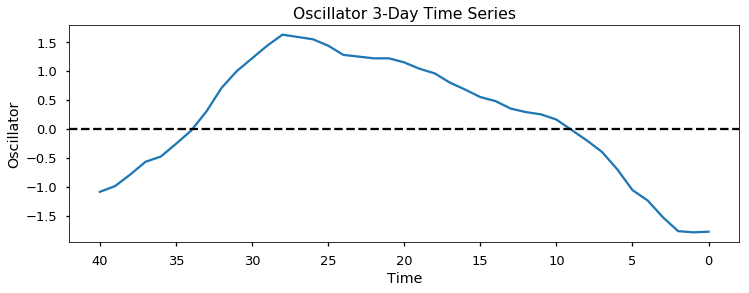

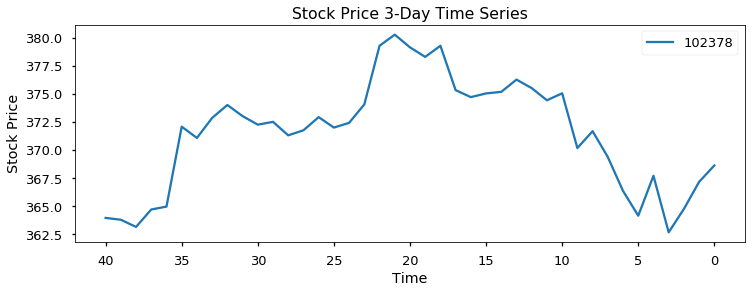

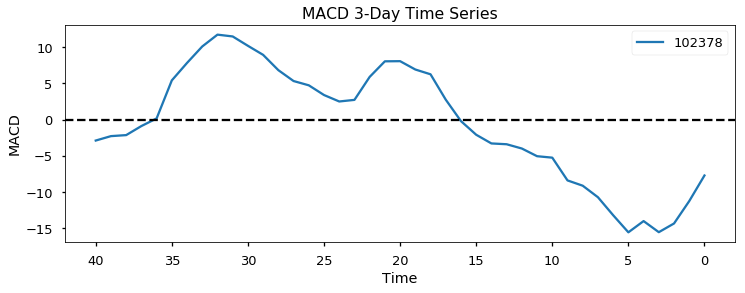

In [114]:
OSC_buy.EDA_visualization(102378,True, True, True)

In [0]:
#OSC_buy.stk_gp

# Let the party begin, we can finally calculated the decline/rise ratio for both the stk and osc!

For the recorded points, those are considered to be the closest turning points before the 

In [0]:
# For osc value

value_rec = []
rise_ratio = []
for i in range(turning_points_rec_for_osc.shape[0]):
  temp_value = []
  col_0 = int(turning_points_rec_for_osc.iloc[i,0])
  col_1 = int(turning_points_rec_for_osc.iloc[i,1])
  col_2 = int(turning_points_rec_for_osc.iloc[i,2])
  
  value_0 = fitted_osc.iloc[i,col_0]
  value_1 = fitted_osc.iloc[i,col_1]
  value_2 = fitted_osc.iloc[i,col_2]
  
  temp_value.append(value_0)
  temp_value.append(value_1)
  temp_value.append(value_2)
  
  value_rec.append(temp_value)
  rise_ratio.append(abs(value_1 - value_2)/abs(value_0 - value_1))

In [159]:
# OSC_buy.stk_gp.shape

(102408, 41)

In [0]:
# turning_points_rec_for_stk.iloc[102408,:]

In [0]:
# for stk value

value_rec_stk = []
rise_ratio_stk = []

for i in range(turning_points_rec_for_stk.shape[0]):
  temp_value = []
  col_0 = int(turning_points_rec_for_stk.iloc[i,0])
  col_1 = int(turning_points_rec_for_stk.iloc[i,1])
  col_2 = int(turning_points_rec_for_stk.iloc[i,2])
  # print(col_0, col_1, col_2)
  # print(i)
  value_0 = fitted_stk.iloc[i,col_0]
  value_1 = fitted_stk.iloc[i,col_1]
  value_2 = fitted_stk.iloc[i,col_2]
  
  temp_value.append(value_0)
  temp_value.append(value_1)
  temp_value.append(value_2)
  
  value_rec_stk.append(temp_value)
  rise_ratio_stk.append(abs(value_1 - value_2)/abs(value_0 - value_1))

In [189]:
turning_points_rec_for_stk.shape

(102408, 3)

# Now we can explore the returns with the rise ratio

In [0]:
osc_rise_ratio = pd.DataFrame({"rise_ratio": rise_ratio,
             "rtn": OSC_buy.rtn_gp})

In [0]:
osc_rise_ratio_clean = osc_rise_ratio[abs(osc_rise_ratio["rise_ratio"]) <= 1]
osc_rise_ratio_clean = osc_rise_ratio_clean[abs(osc_rise_ratio_clean["rtn"]) < 25]


Text(0, 0.5, 'Return')

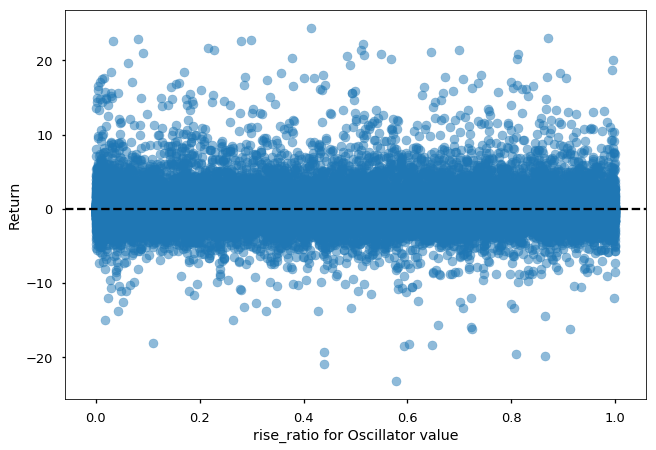

In [51]:
plt.scatter(osc_rise_ratio_clean["rise_ratio"], osc_rise_ratio_clean["rtn"], alpha = 0.5)
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("rise_ratio for Oscillator value")
plt.ylabel("Return")

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

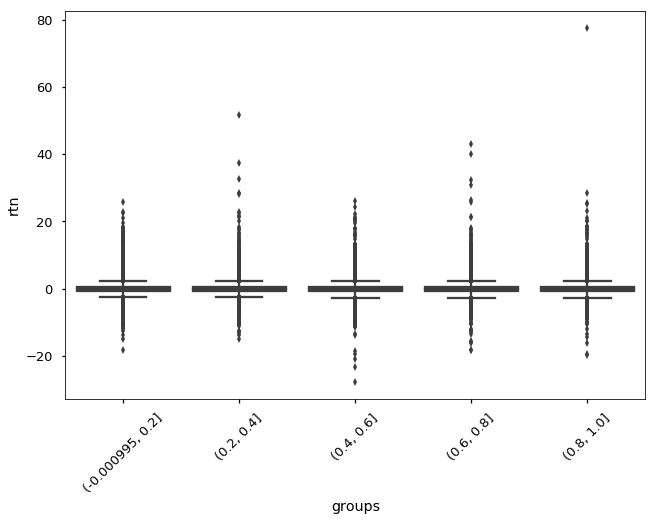

In [45]:
import seaborn as sns
osc_rise_ratio_clean["groups"] = pd.cut(osc_rise_ratio_clean["rise_ratio"], 5)
sns.boxplot(x = "groups", y = "rtn", data = osc_rise_ratio_clean)
plt.xticks(rotation = 45)

In [0]:
stk_rise_ratio = pd.DataFrame({"rise_ratio": rise_ratio_stk,
             "rtn": OSC_buy.rtn_gp})

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

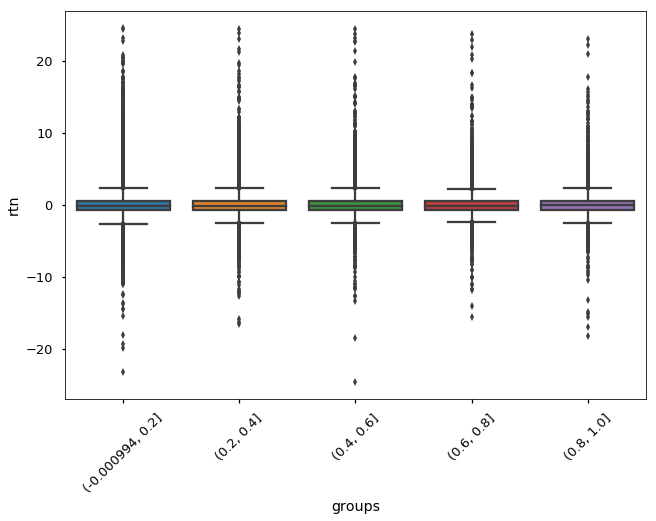

In [48]:

stk_rise_ratio_clean = stk_rise_ratio[abs(stk_rise_ratio["rise_ratio"]) < 1]
stk_rise_ratio_clean = stk_rise_ratio_clean[abs(stk_rise_ratio_clean["rtn"]) < 25]
stk_rise_ratio_clean["groups"] = pd.cut(stk_rise_ratio_clean["rise_ratio"], 5)
sns.boxplot(x = "groups", y = "rtn", data = stk_rise_ratio_clean)
plt.xticks(rotation = 45)

Text(0, 0.5, 'Return')

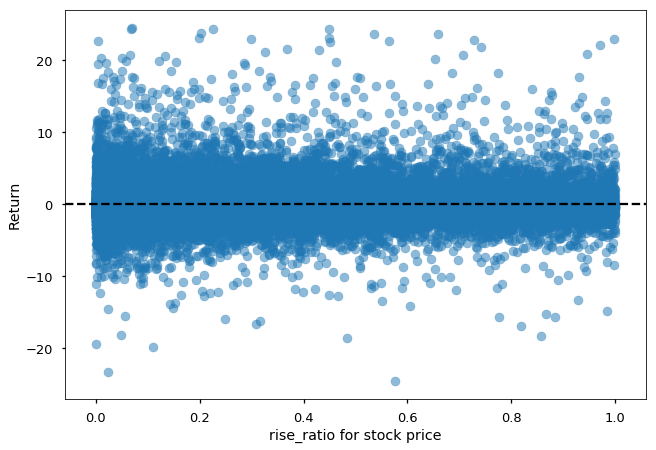

In [49]:
plt.scatter(stk_rise_ratio_clean["rise_ratio"], stk_rise_ratio_clean["rtn"], alpha = 0.5)
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("rise_ratio for stock price")
plt.ylabel("Return")

In [0]:
ratio_diff = [a_i - b_i for a_i, b_i in zip(rise_ratio, rise_ratio_stk)]
combined_results_sign = np.sign(ratio_diff)
rtn_sign = np.sign(OSC_buy.rtn_gp)
combined_results = pd.DataFrame({"ratio_diff": ratio_diff,
                                "ratio_sign": combined_results_sign,
                               "rtn": OSC_buy.rtn_gp,
                               "rtn_sign":rtn_sign })




Text(0, 0.5, 'Return')

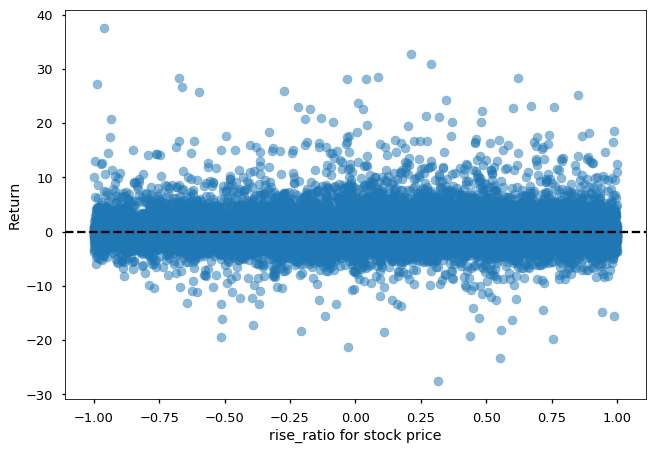

In [64]:
combined_results_cleaned = combined_results[abs(combined_results["ratio_diff"]) < 1]
combined_results_cleaned = combined_results_cleaned[combined_results_cleaned["rtn"] < 125]
plt.scatter(combined_results_cleaned["ratio_diff"], combined_results_cleaned["rtn"], alpha = 0.5)
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("rise_ratio for stock price")
plt.ylabel("Return")

In [0]:
# cobined_results_clean = cobined_results[abs(cobined_results["ratio_diff"]) < 1]

combined_results_clean = combined_results[combined_results["rtn"] < 25]

Text(0.04999999999999716, 0.5, 'Return')

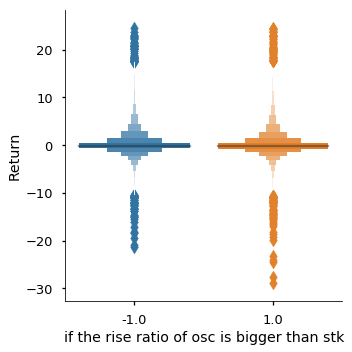

In [67]:
sns.catplot(x = "ratio_sign", y = "rtn", kind = "boxen", data = cobined_results_cleaned)
plt.xlabel("if the rise ratio of osc is bigger than stk")
plt.ylabel("Return")

In [71]:
hm = pd.DataFrame(cobined_results.groupby(["ratio_sign", "rtn_sign"]).count())
hm = hm.reset_index().iloc[:, :-1]
hm = hm.pivot(index = "rtn_sign", columns = "ratio_sign", values = "ratio_diff")
hm

ratio_sign,-1.0,1.0
rtn_sign,,
-1.0,24439,31228
0.0,1544,2002
1.0,18261,22948


In [0]:
hm.iloc[:,0] = hm.iloc[:,0]/(24439+1544+18261)

In [0]:
hm.iloc[:,1] = hm.iloc[:,1]/(31228+2002+22948)

Text(64.00000000000001, 0.5, 'Return, gain or lose')

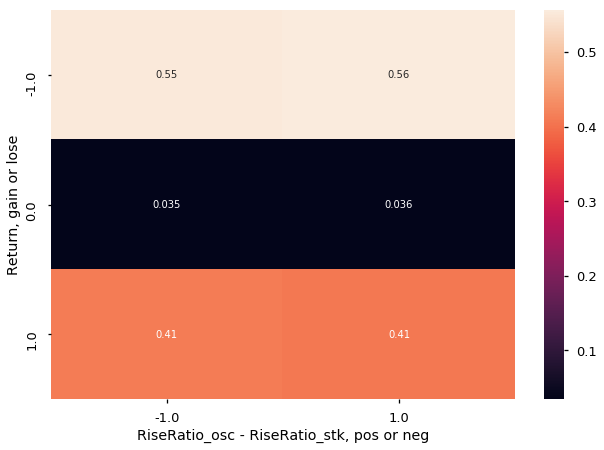

In [83]:
sns.heatmap(hm,annot=True)
plt.xlabel("RiseRatio_osc - RiseRatio_stk, pos or neg")
plt.ylabel("Return, gain or lose")

# Generate Original Features vs. New Features

In [0]:
Features_original = features_generator(df_gp, False, False, False, False)
Feature_psd = features_generator(df_gp, True, False, False, False)
Feature_smooth = features_generator(df_gp, False, True, False, False)
Feature_curvature = features_generator(df_gp, False, False, True, False)
Feature_macd = features_generator(df_gp, False, False, False, True)

After all the feature matrix are generated, don't touch the cell above every again! If we have more features to add, we can add new cells.

Generating features before the model training, reduce the programming time

# Model training with the original features

OSC, STK, and MACD

- **Logistic Regression**

    - Because of its efficient and straightforward nature, doesn't require high computation power, easy to implement, easily interpretable, used widely by data analyst and scientist. Also, it doesn't require scaling of features. Logistic regression provides a probability score for observations.
    - Logistic regression is not able to handle a large number of categorical features/variables. It is vulnerable to overfitting. Also, can't solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features. Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'lbfgs')
precision_pipline(Features_original, model)

Training Accuracy: 0.5889071110914115
Test Accuracy: 0.595527398231762
Test precision: 0.3883495145631068


array([0, 0, 0, ..., 0, 0, 0])

- **Naive Bayes**
    - GaussianNB: implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian
    - Bernoulli Naive Bayes: might not fit in this case

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
precision_pipline(Features_original, model)

Training Accuracy: 0.5595792148693173
Test Accuracy: 0.5628575481064725
Test precision: 0.43171422348072314


array([0, 0, 0, ..., 0, 0, 0])

- **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
precision_pipline(Features_original, model)

Training Accuracy: 0.9810587592157558
Test Accuracy: 0.5670181078908799
Test precision: 0.4504388781845429


array([1, 1, 0, ..., 0, 0, 0])

- **svm** (requires sufficient time for training)

In [0]:
#from sklearn.svm import SVC
#model = SVC(C=100, gamma="scale")
#precision_pipline(Features_original, model)

# Testing the models with psd as new feature

In [0]:
model = LogisticRegression(solver = 'lbfgs')
precision_pipline(Feature_psd, model)

Training Accuracy: 0.5903254879364095
Test Accuracy: 0.5873953950167841
Test precision: 0.42032967032967034


array([0, 0, 1, ..., 0, 0, 0])

In [0]:
model = GaussianNB()
precision_pipline(Feature_psd, model)

Training Accuracy: 0.4174755847110796
Test Accuracy: 0.40811309157959436
Test precision: 0.4025541909282184


array([1, 1, 1, ..., 1, 1, 1])

In [0]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
precision_pipline(Feature_psd, model)

Training Accuracy: 0.982063442814296
Test Accuracy: 0.5683892014561959
Test precision: 0.4572753367189225


array([0, 0, 0, ..., 0, 1, 0])

# Testing the models with smooth as new feature

In [0]:
model = LogisticRegression(solver = 'lbfgs')
precision_pipline(Feature_smooth, model)


Training Accuracy: 0.5881240488749021
Test Accuracy: 0.5902794194127937
Test precision: 0.43283582089552236


array([1, 0, 0, ..., 0, 0, 0])

In [0]:
model = GaussianNB()
precision_pipline(Feature_smooth, model)

Training Accuracy: 0.5450408522080877
Test Accuracy: 0.5471136116495674
Test precision: 0.43059792556436854


array([0, 0, 0, ..., 0, 1, 0])

In [0]:
model = RandomForestClassifier()
precision_pipline(Feature_smooth, model)

Training Accuracy: 0.9804973183812774
Test Accuracy: 0.5735426220982459
Test precision: 0.4553980370774264


array([0, 0, 0, ..., 0, 0, 0])

# Testing models with curvature

In [0]:
model = LogisticRegression(solver = 'lbfgs')
precision_pipline(Feature_curvature, model)

Training Accuracy: 0.5898822451723476
Test Accuracy: 0.5995461207507919
Test precision: 0.4


array([0, 0, 0, ..., 0, 0, 0])

In [0]:
model = GaussianNB()
precision_pipline(Feature_curvature, model)

Training Accuracy: 0.4716398504794409
Test Accuracy: 0.4697650229303579
Test precision: 0.4128452758830283


array([1, 1, 0, ..., 1, 1, 1])

In [0]:
model = RandomForestClassifier()
precision_pipline(Feature_curvature, model)


Training Accuracy: 0.9814576777034115
Test Accuracy: 0.5791688336248877
Test precision: 0.4636992221261884


array([1, 1, 0, ..., 0, 0, 0])

# Testing models with MACD derivitive


In [0]:
model = LogisticRegression(solver = 'lbfgs')
precision_pipline(Feature_macd, model)

Training Accuracy: 0.5887298139857867
Test Accuracy: 0.5937780719587726
Test precision: 0.44565217391304346


array([0, 0, 0, ..., 0, 0, 0])

In [0]:
model = GaussianNB()
precision_pipline(Feature_macd, model)

Training Accuracy: 0.5622386714536886
Test Accuracy: 0.5644650371140845
Test precision: 0.42588522588522587


array([0, 0, 1, ..., 0, 0, 0])

In [0]:
model = RandomForestClassifier()
precision_pipline(Feature_macd, model)

Training Accuracy: 0.9828317302720033
Test Accuracy: 0.5733062266559501
Test precision: 0.4585048754062839


array([0, 1, 0, ..., 0, 0, 1])

# Maybe include other Oscillators 

# Pre-test for NN